In [2]:
import cv2
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder

In [3]:
def process_ui_image(image_path):
    # Load the color image
    image = cv2.imread(image_path)
    # Check if the image was loaded properly
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return None, None, None, None  # Return four None values

    # Apply Gaussian Blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    # Convert the image to grayscale for edge detection
    gray_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Create a copy of the original image to draw contours
    final_image = image.copy()
    detected_components = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Filter out small areas
            x, y, w, h = cv2.boundingRect(contour)
            detected_components.append((x, y, w, h))  # Store bounding box coordinates
            cv2.rectangle(final_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box
    return final_image, gray_image, edges, detected_components


In [4]:
def load_and_preprocess_images(folder_path):

    images = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):  # Add other formats as needed
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image was successfully loaded
                img_resized = cv2.resize(img, (32, 32))
                img_normalized = img_resized.astype(np.float32) / 255.0  # Normalize image to [0, 1]
                images.append(img_normalized)

    return np.array(images)

In [5]:
def extract_labels_from_filenames(folder_path):

    class_labels = []

    for filename in os.listdir(folder_path):
        label = filename.split('-')[-1].split('.')[2]  # Extract class label from filename
        component_name = label.split('.')[-1]  # Get the last part of the label
        class_labels.append(component_name)

    return class_labels

In [58]:
def load_data(folder_path):

    # Load images
    images = load_and_preprocess_images(folder_path)
    # Extract labels
    class_labels = extract_labels_from_filenames(folder_path)
    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(class_labels)
    num_classes = len(encoder.classes_)

    print(f"Loaded {len(images)} images with shape: {images.shape}")
    print(f"Encoded labels: {encoded_labels}")
    print(f"Unique classes: {encoder.classes_}")
    print(f"Number of unique classes: {num_classes}")
    print(f"Length of encoded_labels: {len(encoded_labels)}")


    return images, class_labels, encoded_labels, encoder

In [59]:
train_folder_path = '/kaggle/input/redraw-dataset/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Training_Sampled'

train_images, train_labels, train_labels_encoded, label_encoder = load_data(train_folder_path)
print("-------------------------------------------------------------------------------------------------")
print('Class labels: ', len(train_labels))
print('Encoded labels: ', len(train_labels_encoded))

Loaded 30518 images with shape: (30518, 32, 32, 3)
Encoded labels: [ 0  3  5 ...  4  3 15]
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'ImageView' 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 16
Length of encoded_labels: 30518
-------------------------------------------------------------------------------------------------
Class labels:  30518
Encoded labels:  30518


In [62]:
validation_folder_path = '/kaggle/input/redraw-dataset/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Validation'

validation_images, validation_labels, validation_labels_encoded, _ = load_data(validation_folder_path)

print("-------------------------------------------------------------------------------------------------")
print('Class labels: ', len(validation_labels))
print('Encoded labels: ', len(validation_labels_encoded))

Loaded 28617 images with shape: (28617, 32, 32, 3)
Encoded labels: [14 14 14 ...  0 14 14]
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'ImageView' 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 16
Length of encoded_labels: 57234
-------------------------------------------------------------------------------------------------
Class labels:  57234
Encoded labels:  57234


In [63]:
test_folder_path = '/kaggle/input/redraw-dataset/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Test'

test_images, test_labels, test_labels_encoded, _ = load_data(test_folder_path)

print("-------------------------------------------------------------------------------------------------")
print('Class labels: ', len(test_labels))
print('Encoded labels: ', len(test_labels_encoded))

Loaded 19086 images with shape: (19086, 32, 32, 3)
Encoded labels: [14  5 14 ... 14  0 14]
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'ImageView' 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 16
Length of encoded_labels: 38172
-------------------------------------------------------------------------------------------------
Class labels:  38172
Encoded labels:  38172


In [43]:
# label_encoder = LabelEncoder()
# train_labels_encoded = label_encoder.fit_transform(train_labels)
# val_labels_encoded = label_encoder.transform(validation_labels)
# test_labels_encoded = label_encoder.transform(test_labels)

In [53]:
# Inspect the first few labels
print("First 10 labels:", class_labels[:10])
print("First 10 images:", images[:10])  # Just to see the first few images


NameError: name 'class_labels' is not defined

In [48]:
# Print the new lengths to verify the adjustment
print(len(validation_images), len(validation_labels))
print(len(test_images), len(test_labels))

28617 57234
19086 38172


In [46]:
print(validation_images[:10])  # Check first 10 image paths/names
print(val_labels_encoded[:10])  # Check first 10 corresponding labels


[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1. 

In [12]:
def create_cnn_model(input_shape, num_classes):

    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (32, 32, 3)  # Input image shape
num_classes = len(label_encoder.classes_)  # Number of unique classes in the dataset
model = create_cnn_model(input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,728 (397.38 KB)

 Trainable params: 101,728 (397.38 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train_images, train_labels_encoded, epochs=30, batch_size=4, validation_data=(validation_images, val_labels_encoded),verbose=1)

Epoch 1/30


I0000 00:00:1731169699.053960     106 service.cc:145] XLA service 0x7e04c4005000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731169699.054012     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731169699.054018     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  86/7630 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.1622 - loss: 2.5168     

I0000 00:00:1731169701.749329     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7630/7630 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.3861 - loss: 1.8254 - val_accuracy: 0.2833 - val_loss: 2.4737
Epoch 2/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6407 - loss: 1.1673 - val_accuracy: 0.3051 - val_loss: 2.7047
Epoch 3/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6773 - loss: 1.0215 - val_accuracy: 0.2793 - val_loss: 3.1102
Epoch 4/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7166 - loss: 0.9110 - val_accuracy: 0.3046 - val_loss: 3.4237
Epoch 5/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7349 - loss: 0.8466 - val_accuracy: 0.2969 - val_loss: 3.2328
Epoch 6/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7549 - loss: 0.7785 - val_accuracy: 0.2747 - val_loss: 3.8442
Epoch 7/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7709 - loss: 0.7193 - val_accuracy: 0.2901 - val_loss: 4.1132
Epoch 8/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7904 - loss: 0.6509 - val

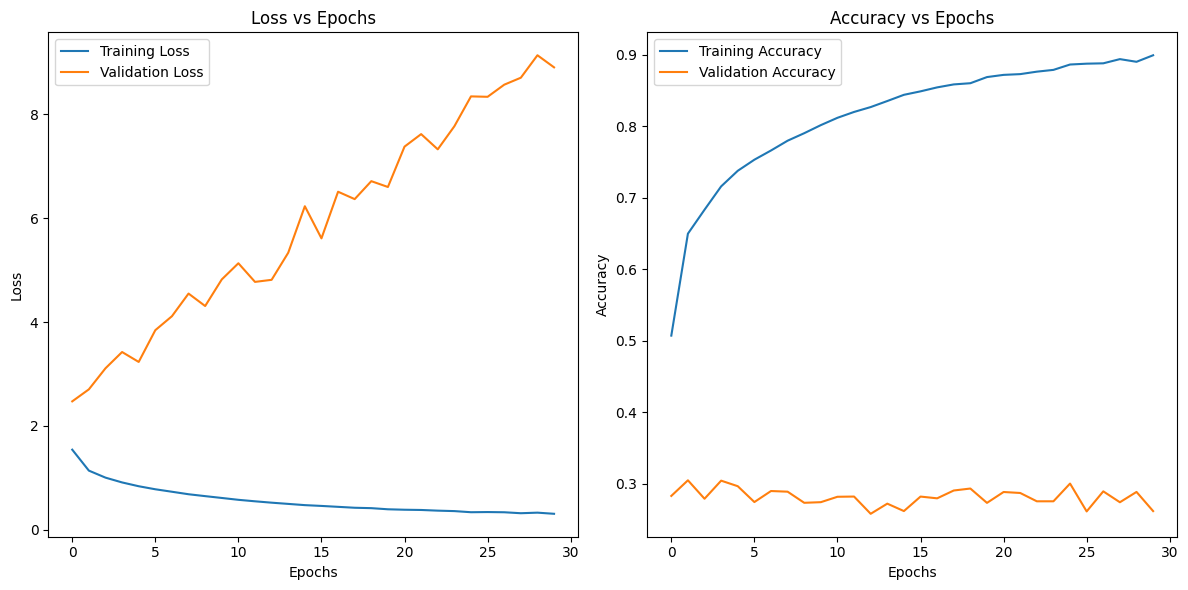

In [14]:
# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
test_error = 1 - test_accuracy

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Error: {test_error * 100:.2f}%")

597/597 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2614 - loss: 8.9158
Test Accuracy: 26.08%
Test Error: 73.92%


In [16]:
validation_loss, validation_accuracy = model.evaluate(validation_images, val_labels_encoded)
validation_error = 1 - validation_accuracy

print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")
print(f"Validation Error: {validation_error * 100:.2f}%")

895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2673 - loss: 8.9152
Validation Accuracy: 26.21%
Validation Error: 73.79%


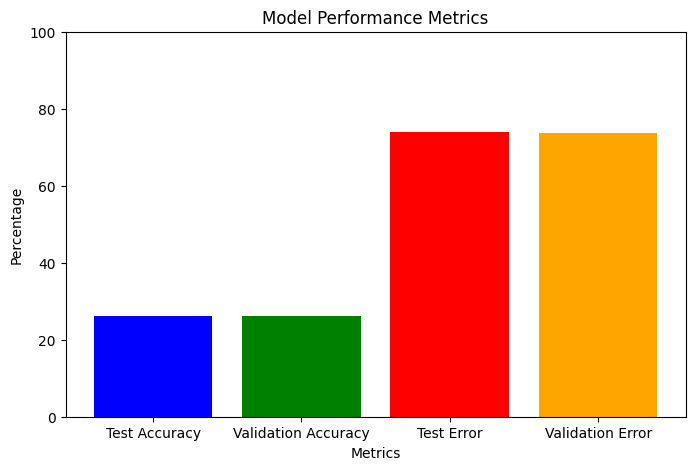

In [17]:
import matplotlib.pyplot as plt

# Data for the plot
metrics = ['Test Accuracy', 'Validation Accuracy', 'Test Error', 'Validation Error']
values = [test_accuracy * 100, validation_accuracy * 100, test_error * 100, validation_error * 100]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Percentage')
plt.title('Model Performance Metrics')
plt.ylim(0, 100)
plt.show()

In [22]:
def predict_on_test_data(test_images):

    # Predict labels for the test images
    predictions = model.predict(test_images)

    # Get the predicted class labels
    predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
    return predicted_labels

# Predict labels for the test data
predicted_test_labels = predict_on_test_data(test_images)

# Print some sample predictions
print("Sample predictions on test data:", predicted_test_labels[:5])

597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Sample predictions on test data: [14  4  0 14 14]


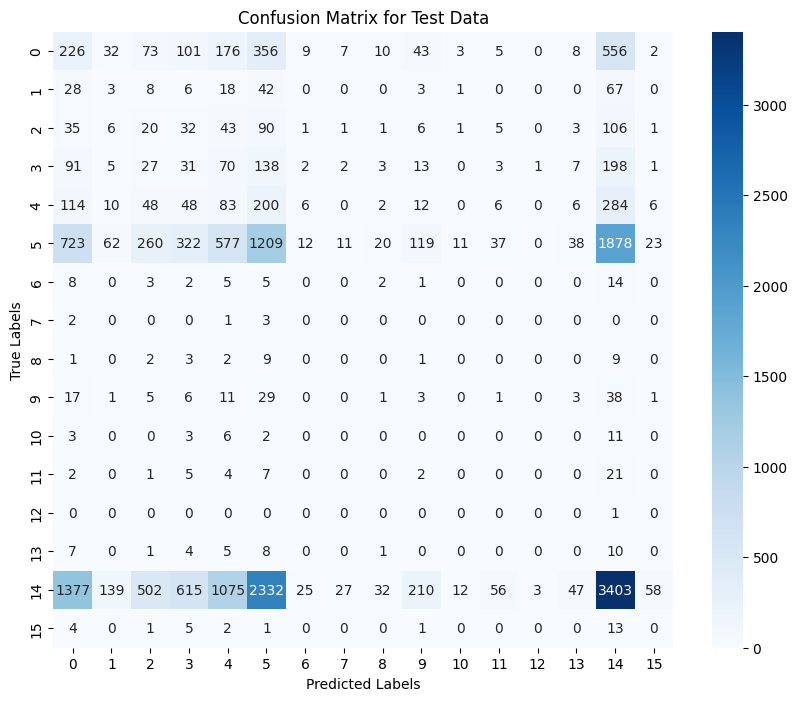

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have encoded test labels: test_labels_encoded
# Generate confusion matrix for the test data
cm = confusion_matrix(test_labels_encoded, predicted_test_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [24]:
def classify_ui_components(image_path, model, encoder):
    processed_image, _, _, detected_components = process_ui_image(image_path)

    if processed_image is None:
        return None, None, None

    # Prepare images for classification
    component_images = []
    for (x, y, w, h) in detected_components:
        component_img = processed_image[y:y+h, x:x+w]
        component_img_resized = cv2.resize(component_img, (32, 32))  # Resize for CNN
        component_images.append(component_img_resized)

    if len(component_images) == 0:
        print("No components detected.")
        return [], detected_components, processed_image

    # Convert list of component images to a numpy array
    component_images_array = np.array(component_images, dtype=np.float32) / 255.0  # Normalize

    # Predict labels for each component
    predictions = model.predict(component_images_array)
    predicted_labels = encoder.inverse_transform(np.argmax(predictions, axis=1))

    return predicted_labels, detected_components, processed_image


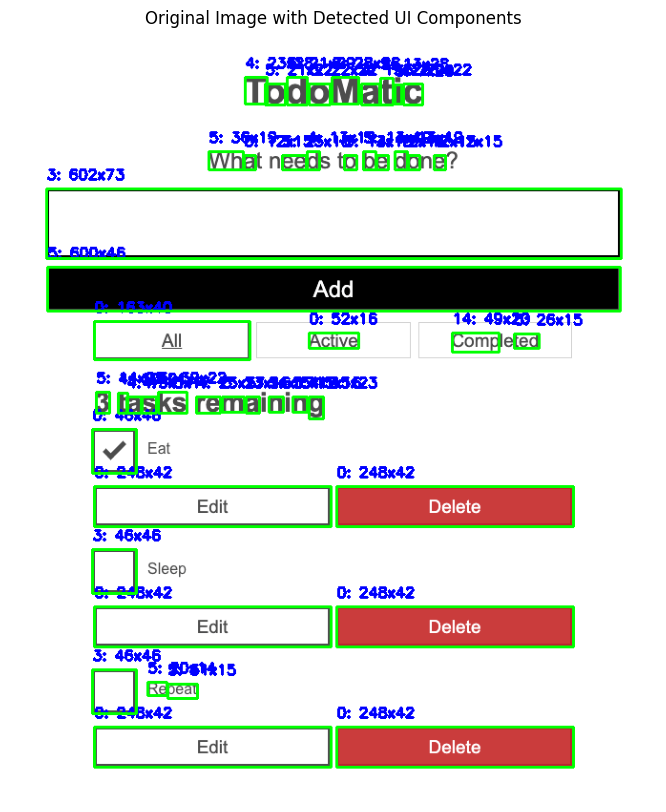

In [40]:
import cv2
import matplotlib.pyplot as plt

# Display the Original Image with Bounding Boxes, Labels, and Dimensions
if processed_image is not None:
    plt.figure(figsize=(10, 10))
    # Convert to RGB for displaying in matplotlib
    image_with_boxes = processed_image.copy()

    # Create a list to hold detected components data
    detected_components_data = []

    # Draw bounding boxes, labels, and dimensions
    for (x, y, w, h), label in zip(detected_components, predicted_labels):
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box
        label_text = f"{label}: {w}x{h}"  # Label text with dimensions
        cv2.putText(image_with_boxes, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Draw label above box in red

        # Append component data to the list
        component_data = {
            "label": label,
            "bounding_box": {
                "x": x,
                "y": y,
                "width": w,
                "height": h
            }
        }
        detected_components_data.append(component_data)

    # Display the image with bounding boxes
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Detected UI Components")
    plt.axis('off')
    plt.show()
else:
    print("No processed image to display.")

In [41]:
import json
import numpy as np

def convert_detections_to_json(predicted_labels, detected_components):
    """
    Convert detected UI components and their labels to JSON format.
    
    Args:
        predicted_labels: List of predicted component labels
        detected_components: List of tuples containing (x, y, width, height)
    
    Returns:
        str: JSON string containing component information
    """
    components_data = []
    
    for label, (x, y, w, h) in zip(predicted_labels, detected_components):
        # Convert numpy values to native Python types
        component = {
            "label": str(label),  # Convert label to string
            "bounding_box": {
                "x": int(x.item() if isinstance(x, np.integer) else x),
                "y": int(y.item() if isinstance(y, np.integer) else y),
                "width": int(w.item() if isinstance(w, np.integer) else w),
                "height": int(h.item() if isinstance(h, np.integer) else h)
            }
        }
        components_data.append(component)
    
    # Convert to JSON string with proper formatting
    json_output = json.dumps(components_data, indent=2)
    return json_output

# Generate JSON
image_path = '/kaggle/input/test-images/images/todo.png'
predicted_labels, detected_components, processed_image = classify_ui_components(image_path, model, label_encoder)

if processed_image is not None:
    # Generate JSON
    json_output = convert_detections_to_json(predicted_labels, detected_components)
    print("Generated JSON:")
    print(json_output)
else:
    print("No processed image to generate JSON.")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Generated JSON:
[
  {
    "label": "0",
    "bounding_box": {
      "x": 342,
      "y": 728,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "0",
    "bounding_box": {
      "x": 88,
      "y": 728,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "5",
    "bounding_box": {
      "x": 165,
      "y": 683,
      "width": 31,
      "height": 15
    }
  },
  {
    "label": "5",
    "bounding_box": {
      "x": 144,
      "y": 681,
      "width": 20,
      "height": 14
    }
  },
  {
    "label": "3",
    "bounding_box": {
      "x": 86,
      "y": 668,
      "width": 46,
      "height": 46
    }
  },
  {
    "label": "0",
    "bounding_box": {
      "x": 342,
      "y": 602,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "0",
    "bounding_box": {
      "x": 88,
      "y": 602,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "3",
    "bounding_box": {
      "x": 86,
      "y"

In [42]:
# Assuming 'predicted_labels' is a list of encoded labels
# The label encoder has a 'classes_' attribute which holds the original class labels

# Get the component names from the label encoder
component_names = label_encoder.classes_

# Map the encoded labels to their respective component names
decoded_labels = [component_names[label] for label in predicted_labels]

# Print the decoded labels with their corresponding names
for encoded_label, component_name in zip(predicted_labels, decoded_labels):
    print(f"Encoded label: {encoded_label} => Component name: {component_name}")


Encoded label: 0 => Component name: 0
Encoded label: 0 => Component name: 0
Encoded label: 5 => Component name: 5
Encoded label: 5 => Component name: 5
Encoded label: 3 => Component name: 3
Encoded label: 0 => Component name: 0
Encoded label: 0 => Component name: 0
Encoded label: 3 => Component name: 3
Encoded label: 0 => Component name: 0
Encoded label: 0 => Component name: 0
Encoded label: 0 => Component name: 0
Encoded label: 4 => Component name: 4
Encoded label: 5 => Component name: 5
Encoded label: 5 => Component name: 5
Encoded label: 5 => Component name: 5
Encoded label: 5 => Component name: 5
Encoded label: 4 => Component name: 4
Encoded label: 4 => Component name: 4
Encoded label: 4 => Component name: 4
Encoded label: 4 => Component name: 4
Encoded label: 5 => Component name: 5
Encoded label: 5 => Component name: 5
Encoded label: 5 => Component name: 5
Encoded label: 14 => Component name: 14
Encoded label: 0 => Component name: 0
Encoded label: 0 => Component name: 0
Encoded la

In [ ]:


def generate_react_component(components):

    react_code = """import React from 'react';



const GeneratedComponent = () => {

  return (

    <div className="relative w-full h-full">\n"""



    for component in components:

        label = component['label']

        box = component['bounding_box']



        # Convert positions to Tailwind-compatible classes

        left_class = f"left-[{box['x']}px]"

        top_class = f"top-[{box['y']}px]"

        width_class = f"w-[{box['width']}px]"

        height_class = f"h-[{box['height']}px]"



        # Add class for the component (example: button, text view)

        react_code += f"""    <div className="{left_class} {top_class} {width_class} {height_class} bg-gray-200">

      <p>{label}</p>

    </div>\n"""



    react_code += """  </div>

  );

};



export default GeneratedComponent;

"""

    return react_code



# Example usage

components_data = [

    {"label": "TextView", "bounding_box": {"x": 10, "y": 20, "width": 100, "height": 40}},

    {"label": "Button", "bounding_box": {"x": 120, "y": 30, "width": 80, "height": 30}}

]



# Generate React code

react_code = generate_react_component(components_data)

print(react_code)


